In [5]:
import math
import numpy as np
from scipy.integrate import quad
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
%pylab inline
from IPython.core.pylabtools import figsize

Populating the interactive namespace from numpy and matplotlib


#### Black Scholes Model Call Value

In [6]:
def Black_Scholes_Model_call_value(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    Black_Scholes_Call = (S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return Black_Scholes_Call

In [7]:
S0 = 100.00    # initial stock price
K = 100.00     # strike price
T = 1.         # call option maturity time  
r = 0.05       # constant short rate
sigma = 0.2    # volatility 

In [8]:
Black_Scholes_Model_call_value(S0, K, T, r, sigma)

10.450583572185565

##### Characteristic function

In [9]:
#Fourier-based approach: characteristic function
def Black_Scholes_Model_characteristic_function(w, s0, T, r, sigma):
    char_fun_value = np.exp(((s0 / T + r - 0.5 * sigma ** 2) * 1j * w - 0.5 * sigma ** 2 * w ** 2) * T )
    return char_fun_value

##### Discrete Fouries Transformation

In [10]:
def DFT(x):
    x_r = []
    x_i = []
    for i in range(len(x)):
        x_r.append(x[i].real)
        x_i.append(x[i].imag)
    #return(x_r,x_i)
    y_r = []
    y_i = []
    y = []
    for k in range(len(x)):
        y_r.append(0.0)
        y_i.append(0.0)
        for n in range(len(x)):
            w_r = cos(-k * n * (2.0) * np.pi / len(x))
            w_i = sin(-k * n * (2.0) * np.pi / len(x))
            t_r = x_r[n] * w_r - x_i[n] * w_i
            t_i = x_r[n] * w_i + x_i[n] * w_r
            y_r[k] += t_r
            y_i[k] += t_i
    for k in range(len(x)):
        #print "%10.4f+%10.4f*i"%(y_r[k],y_i[k])
        y.append(y_r[k])#+y_i[k]*1j)
    return array(y) * 1.0

In [11]:
x = [i for i in range(8)]
#len(x)
x,DFT(x)

([0, 1, 2, 3, 4, 5, 6, 7],
 array([ 28.,  -4.,  -4.,  -4.,  -4.,  -4.,  -4.,  -4.]))

##### Disrete fourier transform Black Soles Model call value

In [12]:
def Black_Scholes_Model_call_value_DFT_simpson(S0, K, T, r, sigma,Grids):

    k = np.log(K)
    s0 = np.log(S0)
    N = Grids                             # N = 2^q => fft based_2
    lambda_ = 1.0/(200.0)                 # λ = lambda_
    # 要使得積分近似要取很小的 η(eta)，但會使 λ(lambda)很大，
    #使得價平附近的履約價格取樣點數太少,為了想要在不失積分準確性又能取到較大的 η
    # Carr and Madan使用辛普森法則加權(Simpson's rule weightings)
    
    eta = (2 * np.pi) / (N * lambda_)      # (2 * π)/ (N * λ) = η
    b = 0.5 * N * lambda_ - k     
    # ku = -b + λ*(u - 1) --> When k = log(K), u = (N/2)-1 --> k = -b + λ*(N/2) --> b = λ*(N/2) - k
    u = np.arange(1, N + 1, 1) 
    wo = eta * (u - 1)                     
    # wo = η * (u - 1) = [(2 * π)/(N * eps)] * (u - 1) , u = 1,...,N
    
    # ψT(wj) = (e^(-rT) * φT(wj - i*(α+1)))/(α^2 + α - wj^2 + i*(2α+1)*wj) , lambda = α ,
    # φT(wj - i*(α+1)) = BSM_characteristic_function(w, x0, T, r, sigma)
    
    alpha = 1.5   # modified rate
    w = wo - (alpha + 1) * 1j
    mod_char_Func = np.exp(-r * T) * (Black_Scholes_Model_characteristic_function(w, s0, T, r, sigma) \
                                    / (alpha ** 2 + alpha - wo ** 2 + 1j * (2 * alpha + 1) * wo))
    delta = np.zeros(1.0 * N)             
    delta[0] = 1                           # delta_(j) = 1 , j = 0 : Kronecker delta function
    j = np.arange(1, N + 1, 1)
    Simpson_weight = (eta * (3 + (-1) ** j - delta))/ 3
    FFT_Func = np.exp(1j * b * wo) * mod_char_Func * Simpson_weight
    Call_Value_M = (np.exp((-1) * alpha * k) / np.pi) * ((DFT(FFT_Func)))
    return Call_Value_M[0.5 * N]

In [13]:
import time 
start = time.time()
BS = Black_Scholes_Model_call_value_DFT_simpson(S0, K, T, r, sigma, 2**12)

end = time.time()
print "BS_DFT = %0.4f.Time taken = %f second"%(BS,end - start)

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


BS_DFT = 10.4506.Time taken = 47.560534 second


/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


##### Implement Cooley-Tukey FFT algorithm

In [14]:
y = []
def ButterFly_Initial_Value(x):
    
    x = asarray(x,dtype = double)
    N = x.shape[0]
    if N == 1:
        y.append(x[0])
    else:
        x_even = ButterFly_Initial_Value(x[::2])
        x_odd = ButterFly_Initial_Value(x[1::2])
    return y

In [15]:
def ButterFly_Structure(y_r,y_i):
    n = 2
    N = len(y_r)
    y = []
    while n <= N:
        for k in range(0,n/2):
            
            w_r = cos(-k * 2.0 * np.pi / n)
            w_i = sin(-k * 2.0 * np.pi / n)
            
            for p in range(k,N,n):
                z = p + n / 2
                
                t_r = w_r * y_r[z] - w_i * y_i[z]
                t_i = w_r * y_i[z] + w_i * y_r[z]
                
                y_r[z] = y_r[p] - t_r
                y_r[p] = y_r[p] + t_r
                
                y_i[z] = y_i[p] - t_i
                y_i[p] = y_i[p] + t_i
        n <<= 1 
    for k in range(N):
        y.append(y_r[k])#+y_i[k]*1j)
    return array(y) * 1.0
        #print "%10.4f + %10.4f*i"%(y_r[k],y_i[k])    

In [16]:
N = 8
x_r = [i for i in range(N)]
x_r = asarray(x_r)
x_i = [0 for i in range(N)]
x_r,x_i

(array([0, 1, 2, 3, 4, 5, 6, 7]), [0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
start = time.time()

y = []
y_r = ButterFly_Initial_Value(x_r)
y = []
y_i = ButterFly_Initial_Value(x_i)

median1 = time.time()
time_len1 = median1 - start 
print "Time taken = ",time_len1,"second"

Time taken =  0.000230073928833 second


In [18]:
y_r,y_i

([0.0, 4.0, 2.0, 6.0, 1.0, 5.0, 3.0, 7.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [19]:
median2 = time.time()

ButterFly_Structure(y_r,y_i)

end = time.time()

time_len2 = end - median2
print "Time taken = ",time_len2,"second"

Time taken =  0.000263929367065 second


In [20]:
def Black_Sholes_Model_call_value_FFT_MY_simpson(S0, K, T, r, sigma,Grids):

    k = np.log(K)
    s0 = np.log(S0)
    N = Grids*1.0                          # N = 2^q => fft based_2
    lambda_ = 1.0/(200.)                   # λ = lambda_
    # 要使得積分近似要取很小的 η(eta)，但會使 λ(lambda)很大，使得價平附近的履約價格取樣點數太少,為了想要在不失積分準確性又能取到較大的 η
    # Carr and Madan使用辛普森法則加權(Simpson's rule weightings)
    eta = (2 * np.pi) / (N * lambda_)      # (2 * π)/ (N * λ) = η
    b = 0.5 * N * lambda_ - k     
    # ku = -b + λ*(u - 1) --> When k = log(K), u = (N/2)-1 --> k = -b + λ*(N/2) --> b = λ*(N/2) - k
    u = np.arange(1, N + 1, 1) 
    wo = eta * (u - 1)                     # wo = η * (u - 1) = [(2 * π)/(N * eps)] * (u - 1) , u = 1,...,N
    
    # ψT(wj) = (e^(-rT) * φT(wj - i*(α+1)))/(α^2 + α - wj^2 + i*(2α+1)*wj) , lambda = α ,
    # φT(wj - i*(α+1)) = BSM_characteristic_function(w, x0, T, r, sigma)
    
    alpha = 1.5 
    w = wo - (alpha + 1) * 1j
    mod_char_Func = np.exp(-r * T) * (Black_Scholes_Model_characteristic_function(w, s0, T, r, sigma) \
                                    / (alpha ** 2 + alpha - wo ** 2 + 1j * (2 * alpha + 1) * wo))
    delta = np.zeros(1.0 * N)             
    delta[0] = 1                           # delta_(j) = 1 , j = 0 : Kronecker delta function
    j = np.arange(1, N + 1, 1)
    Simpson_weight = (eta * (3 + (-1) ** j - delta))/ 3
    FFT_Func = np.exp(1j * b * wo) * mod_char_Func * Simpson_weight
    
    def ButterFly_Initial_Value(x):
    
        x = asarray(x,dtype = double)
        N = x.shape[0]
        if N == 1:
            y.append(x[0])
        else:
            x_even = ButterFly_Initial_Value(x[::2])
            x_odd = ButterFly_Initial_Value(x[1::2])
        return y
    
    y = []
    y_r = ButterFly_Initial_Value(FFT_Func.real)
    y = []
    y_i = ButterFly_Initial_Value(array(FFT_Func).imag)
    def ButterFly_Structure(y_r,y_i):
        n = 2
        N = len(y_r)
        y = []
        while n <= N:
            for k in range(0,n/2):
            
                w_r = cos(-k * 2.0 * np.pi / n)
                w_i = sin(-k * 2.0 * np.pi / n)
            
                for p in range(k,N,n):
                    z = p + n / 2
                    
                    t_r = w_r * y_r[z] - w_i * y_i[z]
                    t_i = w_r * y_i[z] + w_i * y_r[z]
                
                    y_r[z] = y_r[p] - t_r
                    y_r[p] = y_r[p] + t_r
                
                    y_i[z] = y_i[p] - t_i
                    y_i[p] = y_i[p] + t_i
            n <<= 1 
        for k in range(N):
            y.append(y_r[k])
        return array(y) * 1.0
    Call_Value_M = (np.exp((-1) * alpha * k) / np.pi) * (ButterFly_Structure(y_r,y_i))
    return Call_Value_M[0.5 * N]#,Call_Value_M 

In [21]:
import time 
start = time.time()
y = []
BS =  Black_Sholes_Model_call_value_FFT_MY_simpson(S0, K, T, r, sigma, 2**13)

end = time.time()
print "BS = %0.6f.Time taken = %f second"%(BS,end - start)

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


BS = 10.450584.Time taken = 0.145793 second


/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:68: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


##### Use numpy FFT function

In [22]:
def Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, r, sigma,Grids):

    k = np.log(K)
    s0 = np.log(S0)
    N = Grids * 1.0                         # N = 2^q => fft based_2
    lambda_ = 1.0/(200.)                    # λ = lambda_
    # 要使得積分近似要取很小的 η(eta)，但會使 λ(lambda)很大，使得價平附近的履約價格取樣點數太少,為了想要在不失積分準確性又能取到較大的 η
    # Carr and Madan使用辛普森法則加權(Simpson's rule weightings)
    
    eta = (2 * np.pi) / (N * lambda_)       # (2 * π)/ (N * λ) = η
    b = 0.5 * N * lambda_ - k              
    # ku = -b + λ*(u - 1) --> When k = log(K), u = (N/2)-1 --> k = -b + λ*(N/2) --> b = λ*(N/2) - k
    u = np.arange(1, N + 1, 1) 
    wo = eta * (u - 1)                      # wo = η * (u - 1) = [(2 * π)/(N * eps)] * (u - 1) , u = 1,...,N
    
    # ψT(wj) = (e^(-rT) * φT(wj - i*(α+1)))/(α^2 + α - wj^2 + i*(2α+1)*wj) , lambda = α ,
    # φT(wj - i*(α+1)) = BSM_characteristic_function(w, x0, T, r, sigma)
    
    alpha = 1.5                             #(modify)
    w = wo - (alpha + 1) * 1j
    mod_char_Func = np.exp(-r * T) * (Black_Scholes_Model_characteristic_function(w, s0, T, r, sigma) \
                                    / (alpha ** 2 + alpha - wo ** 2 + 1j * (2 * alpha + 1) * wo))
    
    delta = np.zeros(1.0 * N)             
    delta[0] = 1                           # delta_(j) = 1 , j = 0 : Kronecker delta function
    j = np.arange(1, N + 1, 1)
    Simpson_weight = (eta * (3 + (-1) ** j - delta))/ 3
    
    FFT_Func = np.exp(1j * b * wo) * mod_char_Func * Simpson_weight
    #rint(FFT_Func)
    #print(DFT(FFT_Func))
    Call_Value_M = (np.exp((-1) * alpha * k) / np.pi) * ((np.fft.fft(FFT_Func)).real)
     
    return Call_Value_M[0.5 * N] # 對應k的價格在中間

In [23]:
import time 
start = time.time()
bs = Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, r, sigma, 2**12)
end = time.time()
print "BS = %0.6f.Time taken = %f"%(bs,end - start)

BS = 10.450576.Time taken = 0.003948


/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


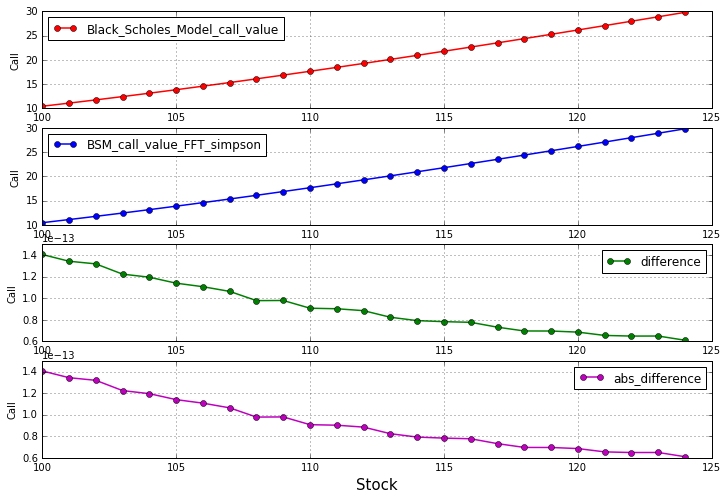

In [24]:
Grids = 2**13
bs = []
x  = [i for i  in arange(100,125,1)]
for i in arange(100,125,1):
    bs.append(Black_Scholes_Model_call_value(i,K,T,r,sigma))
#print(bs)

bs1 = []
for i in arange(100,125,1):
    bs1.append(Black_Scholes_Model_call_value_FFT_simpson(i, K, T, r, sigma,Grids))
#print(bs1)
diff1 = []
for i in arange(100,125,1):
    diff1.append((Black_Scholes_Model_call_value(i,K,T,r,sigma) - 
                  Black_Scholes_Model_call_value_FFT_simpson(i, K, T, r, sigma,Grids))/Black_Scholes_Model_call_value(i,K,T,r,sigma))
#print(diff)
diff2 = []
for i in arange(100,125,1):
    diff2.append(abs((Black_Scholes_Model_call_value(i,K,T,r,sigma) - 
                     Black_Scholes_Model_call_value_FFT_simpson(i, K, T, r, sigma,Grids))/(Black_Scholes_Model_call_value(i,K,T,r,sigma))))
#print(diff)


plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(x, bs, '-o', color = 'r', label='Black_Scholes_Model_call_value', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(412)
plt.plot(x, bs1,'-o', color = 'b', label='BSM_call_value_FFT_simpson', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(413)
plt,plot(x, diff1,'-o', color = 'g', label='difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(414)
plt,plot(x, diff2,'-o', color = 'm', label='abs_difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Stock',size = 15)
plt.ylabel('Call',size = 10)
#plt.tight_layout()

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


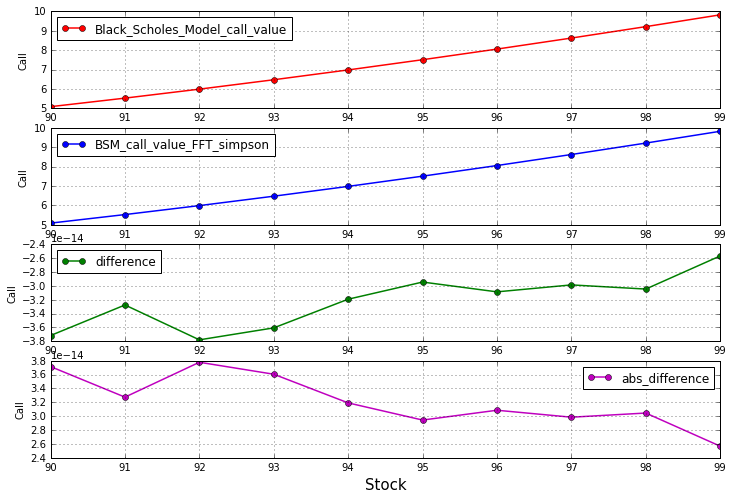

In [25]:
Grids = 2**15
bs = []
x  = [i for i  in arange(90,100,1)]
for i in arange(90,100,1):
    bs.append(Black_Scholes_Model_call_value(i,K,T,r,sigma))
#print(bs)

bs1 = []
for i in arange(90,100,1):
    bs1.append(Black_Scholes_Model_call_value_FFT_simpson(i, K, T, r, sigma,Grids))
#print(bs1)
diff1 = []
for i in arange(90,100,1):
    diff1.append((Black_Scholes_Model_call_value(i,K,T,r,sigma) - 
                  Black_Scholes_Model_call_value_FFT_simpson(i, K, T, r, sigma,Grids))/Black_Scholes_Model_call_value(i,K,T,r,sigma))
#print(diff)
diff2 = []
for i in arange(90,100,1):
    diff2.append(abs((Black_Scholes_Model_call_value(i,K,T,r,sigma) - 
                     Black_Scholes_Model_call_value_FFT_simpson(i, K, T, r, sigma,Grids))/(Black_Scholes_Model_call_value(i,K,T,r,sigma))))
#print(diff)


plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(x, bs, '-o', color = 'r', label='Black_Scholes_Model_call_value', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(412)
plt.plot(x, bs1,'-o', color = 'b', label='BSM_call_value_FFT_simpson', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(413)
plt,plot(x, diff1,'-o', color = 'g', label='difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(414)
plt,plot(x, diff2,'-o', color = 'm', label='abs_difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Stock',size = 15)
plt.ylabel('Call',size = 10)
#plt.tight_layout()

In [26]:
[i for i in arange(20,25,0.5)]

[20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5]

In [27]:
arange(20,25,0.5)

array([ 20. ,  20.5,  21. ,  21.5,  22. ,  22.5,  23. ,  23.5,  24. ,  24.5])

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


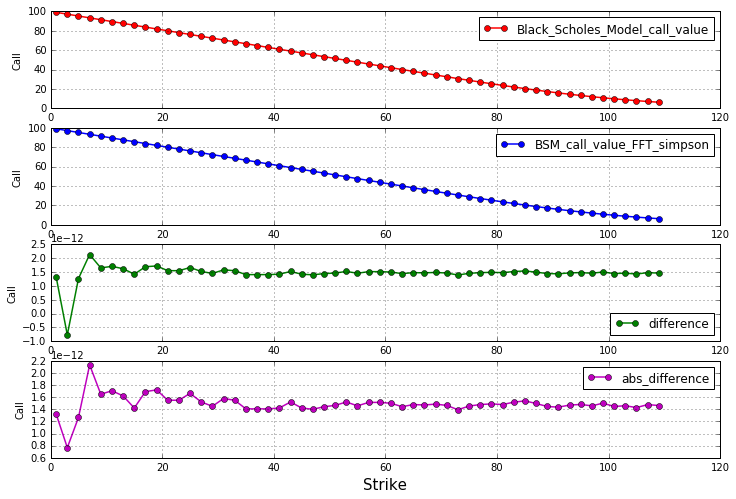

In [28]:
Grids = 2**13
x = [i for i in range(1,110,2)]
bs = []
for i in range(1,110,2):
    bs.append(Black_Scholes_Model_call_value(S0,i,T,r,sigma))
#print(bs)

bs1 = []
for i in range(1,110,2):
    bs1.append(Black_Scholes_Model_call_value_FFT_simpson(S0, i, T, r, sigma,Grids))
#print(bs1)
diff1 = []
for i in range(1,110,2):
    diff1.append(Black_Scholes_Model_call_value(S0,i,T,r,sigma) - Black_Scholes_Model_call_value_FFT_simpson(S0, i, T, r, sigma,Grids))
#print(diff)
diff2 = []
for i in range(1,110,2):
    diff2.append(abs(Black_Scholes_Model_call_value(S0,i,T,r,sigma) - Black_Scholes_Model_call_value_FFT_simpson(S0, i, T, r, sigma,Grids)))
#print(diff)


plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(x, bs, '-o', color = 'r', label='Black_Scholes_Model_call_value', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(412)
plt.plot(x, bs1,'-o', color = 'b', label='BSM_call_value_FFT_simpson', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(413)
plt,plot(x, diff1,'-o', color = 'g', label='difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(414)
plt,plot(x, diff2,'-o', color = 'm', label='abs_difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Strike',size = 15)
plt.ylabel('Call',size = 10)
#plt.tight_layout()

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


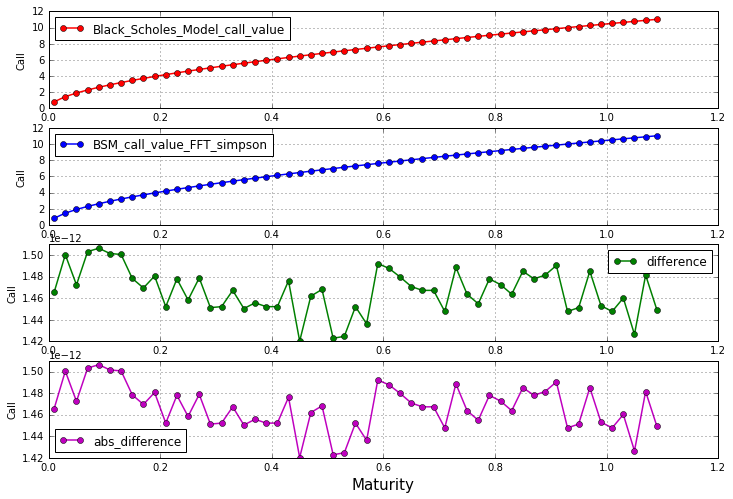

In [29]:
Grids = 2**13
x = [i/100.0 for i in range(1,110,2)]
bs = []
for i in range(1,110,2):
    bs.append(Black_Scholes_Model_call_value(S0,K,(i/100.0),r,sigma))
#print(bs)

bs1 = []
for i in range(1,110,2):
    bs1.append(Black_Scholes_Model_call_value_FFT_simpson(S0, K, (i/100.0), r, sigma,Grids))
#print(bs1)
diff1 = []
for i in range(1,110,2):
    diff1.append(Black_Scholes_Model_call_value(S0,K,(i/100.0),r,sigma) - Black_Scholes_Model_call_value_FFT_simpson(S0, K, (i/100.0), r, sigma,Grids))
#print(diff)
diff2 = []
for i in range(1,110,2):
    diff2.append(abs(Black_Scholes_Model_call_value(S0,K,(i/100.0),r,sigma) - Black_Scholes_Model_call_value_FFT_simpson(S0, K, (i/100.0), r, sigma,Grids)))
#print(diff)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(x, bs, '-o', color = 'r', label='Black_Scholes_Model_call_value', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(412)
plt.plot(x, bs1,'-o', color = 'b', label='BSM_call_value_FFT_simpson', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(413)
plt,plot(x, diff1,'-o', color = 'g', label='difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(414)
plt,plot(x, diff2,'-o', color = 'm', label='abs_difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Maturity',size = 15)
plt.ylabel('Call',size = 10)
#plt.tight_layout()

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


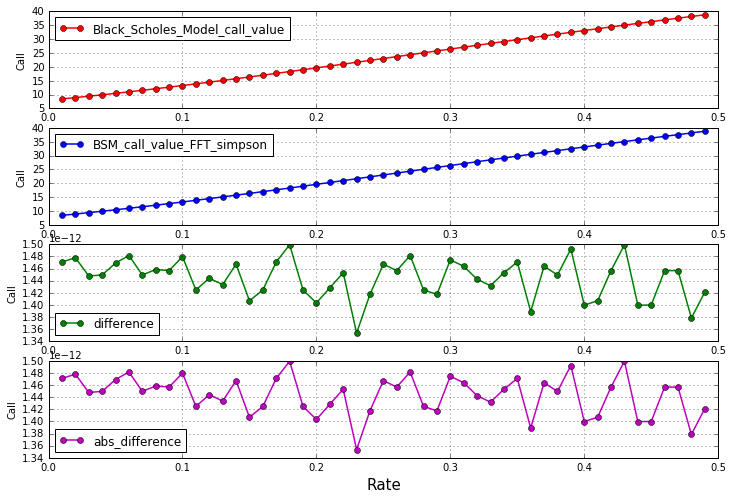

In [30]:
Grids = 2**13
x = [i/(100.0) for i in range(1,50,1)]
bs = []
for i in range(1,50,1):
    bs.append(Black_Scholes_Model_call_value(S0,K,T,(i/100.0),sigma))
#print(bs)

bs1 = []
for i in range(1,50,1):
    bs1.append(Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, (i/100.0), sigma,Grids))
#print(bs1)
diff1 = []
for i in range(1,50,1):
    diff1.append(Black_Scholes_Model_call_value(S0,K,T,(i/100.0),sigma) - Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, (i/100.0), sigma,Grids))
#print(diff)
diff2 = []
for i in range(1,50,1):
    diff2.append(abs(Black_Scholes_Model_call_value(S0,K,T,(i/100.0),sigma) - Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, (i/100.0), sigma,Grids)))
#print(diff)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(x, bs, '-o', color = 'r', label='Black_Scholes_Model_call_value', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(412)
plt.plot(x, bs1,'-o', color = 'b', label='BSM_call_value_FFT_simpson', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(413)
plt,plot(x, diff1,'-o', color = 'g', label='difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(414)
plt,plot(x, diff2,'-o', color = 'm', label='abs_difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Rate',size = 15)
plt.ylabel('Call',size = 10)
#plt.tight_layout()

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


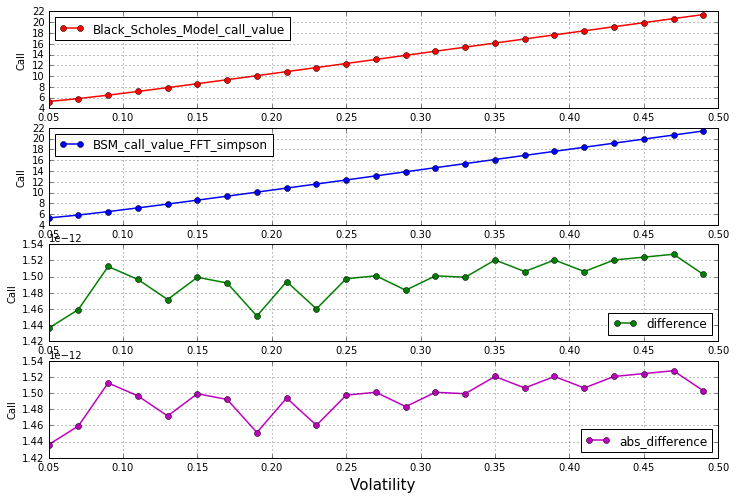

In [31]:
Grids = 2**13
x = [i/(100.0) for i in range(5,50,2)]
bs = []
for i in range(5,50,2):
    bs.append(Black_Scholes_Model_call_value(S0,K,T,r,(i/100.0)))
#print(bs)

bs1 = []
for i in range(5,50,2):
    bs1.append(Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, r, (i/100.0),Grids))
#print(bs1)
diff1 = []
for i in range(5,50,2):
    diff1.append(Black_Scholes_Model_call_value(S0,K,T,r,(i/100.0)) - Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, r, (i/100.0),Grids))
#print(diff)
diff2 = []
for i in range(5,50,2):
    diff2.append(abs(Black_Scholes_Model_call_value(S0,K,T,r,(i/100.0)) - Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, r, (i/100.0),Grids)))
#print(diff)

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(x, bs, '-o', color = 'r', label='Black_Scholes_Model_call_value', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(412)
plt.plot(x, bs1,'-o', color = 'b', label='BSM_call_value_FFT_simpson', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(413)
plt,plot(x, diff1,'-o', color = 'g', label='difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.ylabel('Call',size = 10)
plt.subplot(414)
plt,plot(x, diff2,'-o', color = 'm', label='abs_difference', lw=1.5)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Volatility',size = 15)
plt.ylabel('Call',size = 10)
#plt.tight_layout()

#### DFT Time

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


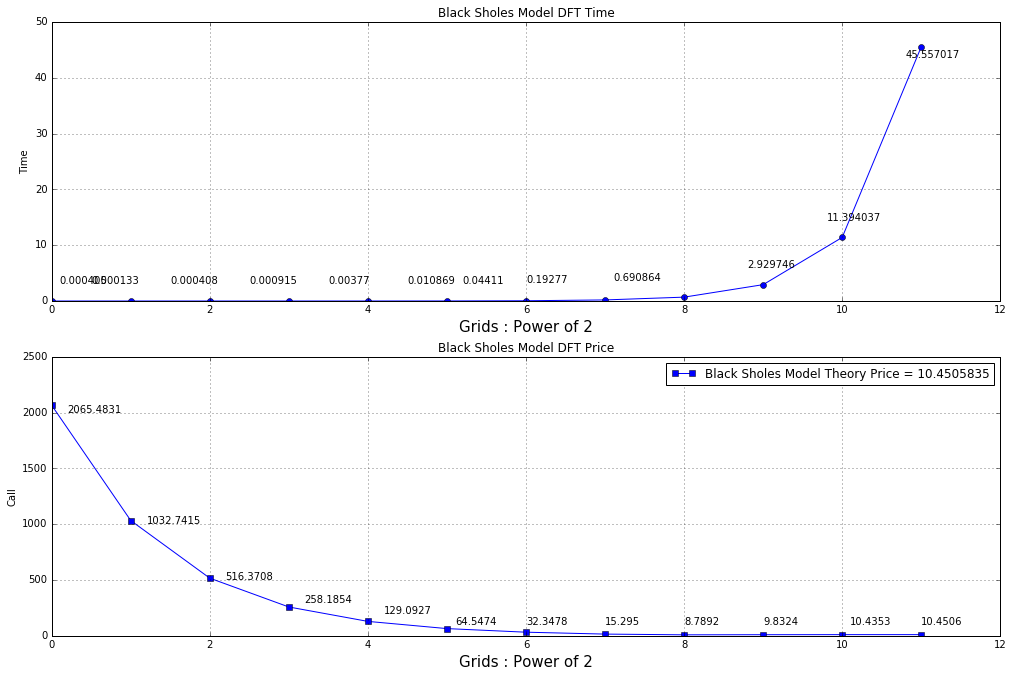

In [32]:
import time 
BSM_call_value_DFT = []
time_ = []
for i in range(1,13):
    start = time.time()
    BSM_call_value_DFT.append(Black_Scholes_Model_call_value_DFT_simpson(S0, K, T, r, sigma,2**i))
    end = time.time()
    times = end - start
    time_.append(times)
#print time_,BSM_call_value_DFT
plt.figure(figsize=(17, 11))
plt.subplot(2,1,1)
plt.plot(time_,'-o')#,BSM_call_value_DFT)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Grids : Power of 2',size = 15)
plt.ylabel('Time',size = 10)
plt.title('Black Sholes Model DFT Time')
plt.annotate(round(time_[0],6), xy=(1, 0.1), xytext=(0.1, round(time_[0],6)+3))
plt.annotate(round(time_[1],6), xy=(2, 0.1), xytext=(0.5, round(time_[1],6)+3))
plt.annotate(round(time_[2],6), xy=(3, 0.1), xytext=(1.5, round(time_[2],6)+3))
plt.annotate(round(time_[3],6), xy=(4, 0.1), xytext=(2.5, round(time_[3],6)+3))
plt.annotate(round(time_[4],6), xy=(5, 0.1), xytext=(3.5, round(time_[4],6)+3))
plt.annotate(round(time_[5],6), xy=(6, 0.1), xytext=(4.5, round(time_[5],6)+3))
plt.annotate(round(time_[6],6), xy=(7, 0.1), xytext=(5.2, round(time_[6],6)+3))
plt.annotate(round(time_[7],6), xy=(8, 0.1), xytext=(6.0, round(time_[7],6)+3))
plt.annotate(round(time_[8],6), xy=(9, 0.1), xytext=(7.1, round(time_[8],6)+3))
plt.annotate(round(time_[9],6), xy=(10, 0.1), xytext=(8.8, round(time_[9],6)+3))
plt.annotate(round(time_[10],6), xy=(11, 0.1), xytext=(9.8, round(time_[10],6)+3))
plt.annotate(round(time_[11],6), xy=(12, 0.1), xytext=(10.8, round(time_[11],6)-2))

plt.subplot(2,1,2)
plt.plot(BSM_call_value_DFT,'-bs',label = 'Black Sholes Model Theory Price = 10.4505835')
plt.grid()
plt.legend(loc=0)
plt.xlabel('Grids : Power of 2',size = 15)
plt.ylabel('Call',size = 10)
plt.title('Black Sholes Model DFT Price')
plt.annotate(round(BSM_call_value_DFT[0],4), xy=(1, 0.1), xytext=(0.2, 2000))
plt.annotate(round(BSM_call_value_DFT[1],4), xy=(1, 0.1), xytext=(1.2, 1000))
plt.annotate(round(BSM_call_value_DFT[2],4), xy=(1, 0.1), xytext=(2.2, 500))
plt.annotate(round(BSM_call_value_DFT[3],4), xy=(1, 0.1), xytext=(3.2, 300))
plt.annotate(round(BSM_call_value_DFT[4],4), xy=(1, 0.1), xytext=(4.2, 200))
plt.annotate(round(BSM_call_value_DFT[5],4), xy=(1, 0.1), xytext=(5.1, 100))
plt.annotate(round(BSM_call_value_DFT[6],4), xy=(1, 0.1), xytext=(6.0, 100))
plt.annotate(round(BSM_call_value_DFT[7],4), xy=(1, 0.1), xytext=(7.0, 100))
plt.annotate(round(BSM_call_value_DFT[8],4), xy=(1, 0.1), xytext=(8.0, 100))
plt.annotate(round(BSM_call_value_DFT[9],4), xy=(1, 0.1), xytext=(9.0, 100))
plt.annotate(round(BSM_call_value_DFT[10],4), xy=(1, 0.1), xytext=(10.1, 100))
plt.annotate(round(BSM_call_value_DFT[11],4), xy=(1, 0.1), xytext=(11.0, 100))

#### FFT My TIME

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:68: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


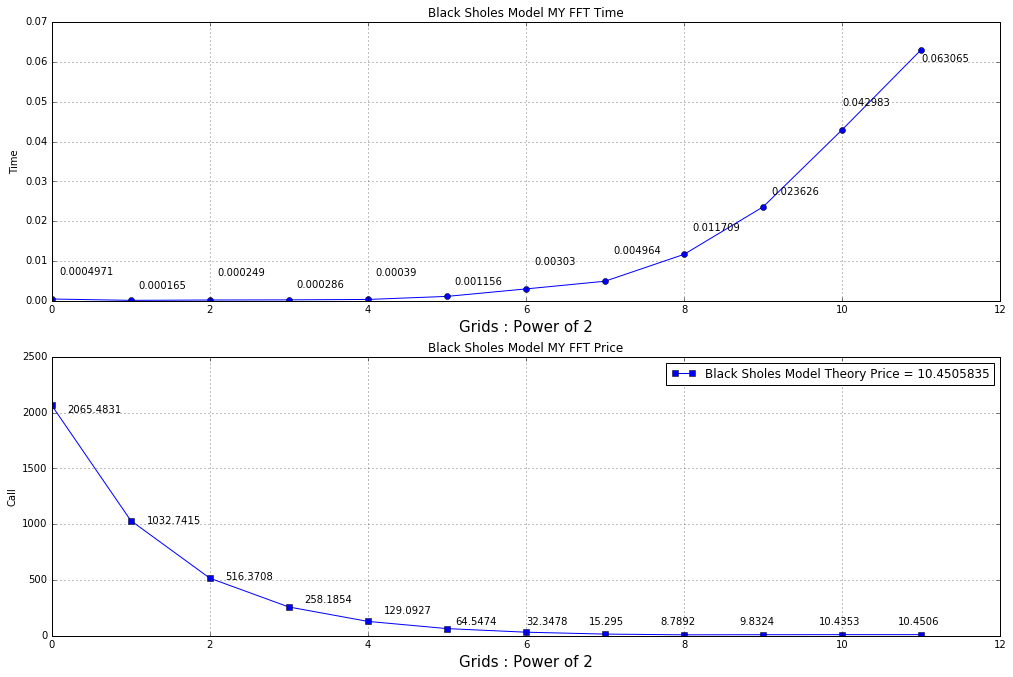

In [33]:
import time 
BSM_call_value_FFT = []
time_ = []
for i in range(1,13):
    start = time.time()
    BSM_call_value_FFT.append(Black_Sholes_Model_call_value_FFT_MY_simpson(S0, K, T, r, sigma,2**i))
    end = time.time()
    times = end - start
    time_.append(times)
#print time_,BSM_call_value_DFT
plt.figure(figsize=(17, 11))
#plt.subplot(2,2,1)
plt.subplot(2,1,1)
plt.plot(time_,'-o')#,BSM_call_value_DFT)
plt.grid()
plt.xlabel('Grids : Power of 2',size = 15)
plt.ylabel('Time',size = 10)
plt.title('Black Sholes Model MY FFT Time')
plt.annotate(round(time_[0],8), xy=(1, 0.001), xytext=(0.1, round(time_[0],8)+0.006))
plt.annotate(round(time_[1],6), xy=(1, 0.001), xytext=(1.1, round(time_[1],8)+0.003))
plt.annotate(round(time_[2],6), xy=(1, 0.001), xytext=(2.1, round(time_[2],8)+0.006))
plt.annotate(round(time_[3],6), xy=(1, 0.001), xytext=(3.1, round(time_[3],8)+0.003))
plt.annotate(round(time_[4],6), xy=(1, 0.001), xytext=(4.1, round(time_[4],8)+0.006))
plt.annotate(round(time_[5],6), xy=(1, 0.001), xytext=(5.1, round(time_[5],8)+0.003))
plt.annotate(round(time_[6],6), xy=(1, 0.001), xytext=(6.1, round(time_[6],8)+0.006))
plt.annotate(round(time_[7],6), xy=(1, 0.001), xytext=(7.1, round(time_[7],8)+0.007))
plt.annotate(round(time_[8],6), xy=(1, 0.001), xytext=(8.1, round(time_[8],8)+0.006))
plt.annotate(round(time_[9],6), xy=(1, 0.001), xytext=(9.1, round(time_[9],8)+0.003))
plt.annotate(round(time_[10],6), xy=(1, 0.001), xytext=(10.0, round(time_[10],8)+0.006))
plt.annotate(round(time_[11],6), xy=(1, 0.001), xytext=(11.0, round(time_[11],8)-0.003))

#plt.subplot(2,2,2)
plt.subplot(2,1,2)
plt.plot(BSM_call_value_FFT,'-bs',label = 'Black Sholes Model Theory Price = 10.4505835')
plt.grid()
plt.legend(loc=0)
plt.xlabel('Grids : Power of 2',size = 15)
plt.ylabel('Call',size = 10)
plt.title('Black Sholes Model MY FFT Price')
plt.annotate(round(BSM_call_value_FFT[0],4), xy=(1, 0.1), xytext=(0.2, 2000))
plt.annotate(round(BSM_call_value_FFT[1],4), xy=(1, 0.1), xytext=(1.2, 1000))
plt.annotate(round(BSM_call_value_FFT[2],4), xy=(1, 0.1), xytext=(2.2, 500))
plt.annotate(round(BSM_call_value_FFT[3],4), xy=(1, 0.1), xytext=(3.2, 300))
plt.annotate(round(BSM_call_value_FFT[4],4), xy=(1, 0.1), xytext=(4.2, 200))
plt.annotate(round(BSM_call_value_FFT[5],4), xy=(1, 0.1), xytext=(5.1, 100))
plt.annotate(round(BSM_call_value_FFT[6],4), xy=(1, 0.1), xytext=(6.0, 100))
plt.annotate(round(BSM_call_value_FFT[7],4), xy=(1, 0.1), xytext=(6.8, 100))
plt.annotate(round(BSM_call_value_FFT[8],4), xy=(1, 0.1), xytext=(7.7, 100))
plt.annotate(round(BSM_call_value_FFT[9],4), xy=(1, 0.1), xytext=(8.7, 100))
plt.annotate(round(BSM_call_value_FFT[10],4), xy=(1, 0.1), xytext=(9.7, 100))
plt.annotate(round(BSM_call_value_FFT[11],4), xy=(1, 0.1), xytext=(10.7, 100))


#### FFT numpy.fft time  

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


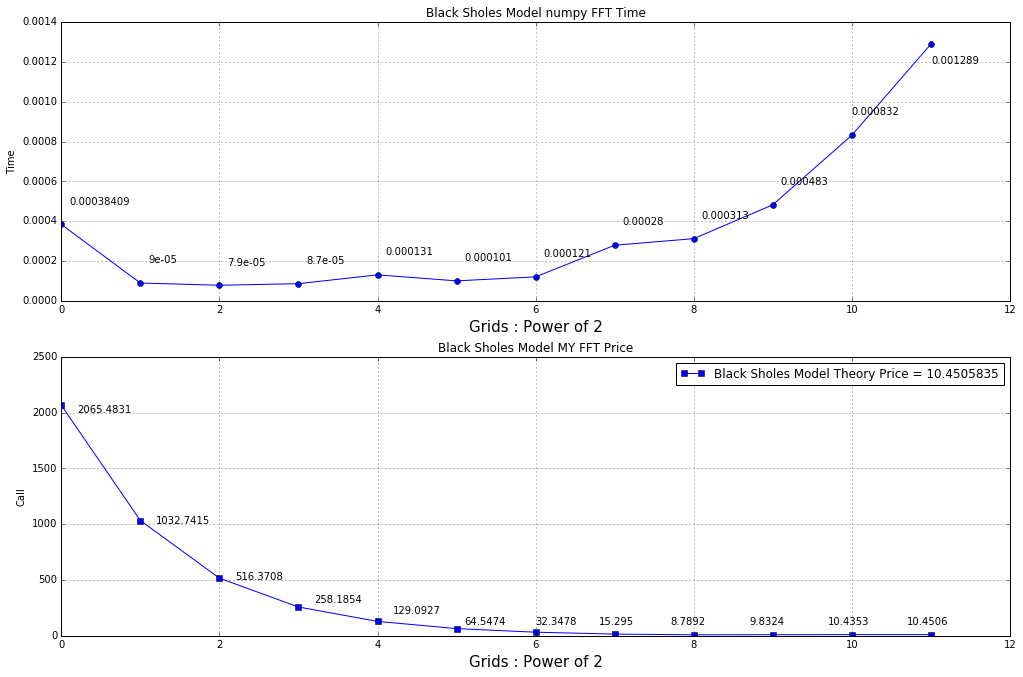

In [34]:
import time 
BSM_call_value_FFT = []
time_ = []
for i in range(1,13):
    start = time.time()
    BSM_call_value_FFT.append(Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, r, sigma,2**i))
    end = time.time()
    times = end - start
    time_.append(times)
plt.figure(figsize=(17, 11))
plt.subplot(2,1,1)
plt.plot(time_,'-o')
plt.grid()
plt.xlabel('Grids : Power of 2',size = 15)
plt.ylabel('Time',size = 10)
plt.title('Black Sholes Model numpy FFT Time')
plt.annotate(round(time_[0],8), xy=(1, 0.001), xytext=(0.1, round(time_[0],8)+0.0001))
plt.annotate(round(time_[1],6), xy=(1, 0.001), xytext=(1.1, round(time_[1],8)+0.0001))
plt.annotate(round(time_[2],6), xy=(1, 0.001), xytext=(2.1, round(time_[2],8)+0.0001))
plt.annotate(round(time_[3],6), xy=(1, 0.001), xytext=(3.1, round(time_[3],8)+0.0001))
plt.annotate(round(time_[4],6), xy=(1, 0.001), xytext=(4.1, round(time_[4],8)+0.0001))
plt.annotate(round(time_[5],6), xy=(1, 0.001), xytext=(5.1, round(time_[5],8)+0.0001))
plt.annotate(round(time_[6],6), xy=(1, 0.001), xytext=(6.1, round(time_[6],8)+0.0001))
plt.annotate(round(time_[7],6), xy=(1, 0.001), xytext=(7.1, round(time_[7],8)+0.0001))
plt.annotate(round(time_[8],6), xy=(1, 0.001), xytext=(8.1, round(time_[8],8)+0.0001))
plt.annotate(round(time_[9],6), xy=(1, 0.001), xytext=(9.1, round(time_[9],8)+0.0001))
plt.annotate(round(time_[10],6), xy=(1, 0.001), xytext=(10.0, round(time_[10],8)+0.0001))
plt.annotate(round(time_[11],6), xy=(1, 0.001), xytext=(11.0, round(time_[11],8)-0.0001))

#plt.subplot(2,2,2)
plt.subplot(2,1,2)
plt.plot(BSM_call_value_FFT,'-bs',label = 'Black Sholes Model Theory Price = 10.4505835')
plt.grid()
plt.legend(loc=0)
plt.xlabel('Grids : Power of 2',size = 15)
plt.ylabel('Call',size = 10)
plt.title('Black Sholes Model MY FFT Price')
plt.annotate(round(BSM_call_value_FFT[0],4), xy=(1, 0.1), xytext=(0.2, 2000))
plt.annotate(round(BSM_call_value_FFT[1],4), xy=(1, 0.1), xytext=(1.2, 1000))
plt.annotate(round(BSM_call_value_FFT[2],4), xy=(1, 0.1), xytext=(2.2, 500))
plt.annotate(round(BSM_call_value_FFT[3],4), xy=(1, 0.1), xytext=(3.2, 300))
plt.annotate(round(BSM_call_value_FFT[4],4), xy=(1, 0.1), xytext=(4.2, 200))
plt.annotate(round(BSM_call_value_FFT[5],4), xy=(1, 0.1), xytext=(5.1, 100))
plt.annotate(round(BSM_call_value_FFT[6],4), xy=(1, 0.1), xytext=(6.0, 100))
plt.annotate(round(BSM_call_value_FFT[7],4), xy=(1, 0.1), xytext=(6.8, 100))
plt.annotate(round(BSM_call_value_FFT[8],4), xy=(1, 0.1), xytext=(7.7, 100))
plt.annotate(round(BSM_call_value_FFT[9],4), xy=(1, 0.1), xytext=(8.7, 100))
plt.annotate(round(BSM_call_value_FFT[10],4), xy=(1, 0.1), xytext=(9.7, 100))
plt.annotate(round(BSM_call_value_FFT[11],4), xy=(1, 0.1), xytext=(10.7, 100))

#### DFT / FFT TIME

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


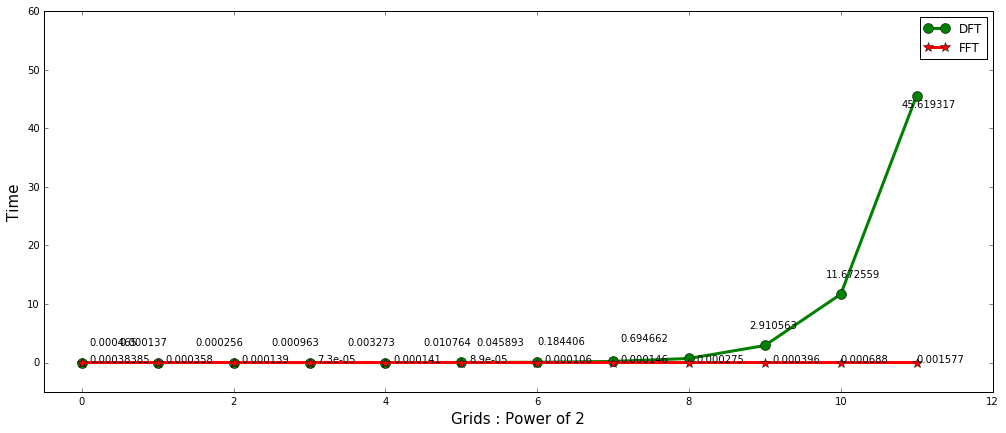

In [35]:
import time 
BSM_call_value_DFT = []
time1_ = []
for i in range(1,13):
    start = time.time()
    BSM_call_value_DFT.append(Black_Scholes_Model_call_value_DFT_simpson(S0, K, T, r, sigma,2**i))
    end = time.time()
    times = end - start
    time1_.append(times)

BSM_call_value_FFT = []
time2_ = []
for i in range(1,13):
    start = time.time()
    BSM_call_value_FFT.append(Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, r, sigma,2**i))
    end = time.time()
    times = end - start
    time2_.append(times)

plt.figure(figsize=(17, 15))
plt.subplot(2,1,1)
plt.plot(time1_,'-o',label = 'DFT',color = 'g',lw = 3,markersize = 10)
plt.grid()
plt.legend(loc=0)
plt.xlabel('Grids : Power of 2',size = 15)
plt.ylabel('Time',size = 15)
plt.annotate(round(time1_[0],6), xy=(1, 0.1), xytext=(0.1, round(time1_[0],6)+3))
plt.annotate(round(time1_[1],6), xy=(2, 0.1), xytext=(0.5, round(time1_[1],6)+3))
plt.annotate(round(time1_[2],6), xy=(3, 0.1), xytext=(1.5, round(time1_[2],6)+3))
plt.annotate(round(time1_[3],6), xy=(4, 0.1), xytext=(2.5, round(time1_[3],6)+3))
plt.annotate(round(time1_[4],6), xy=(5, 0.1), xytext=(3.5, round(time1_[4],6)+3))
plt.annotate(round(time1_[5],6), xy=(6, 0.1), xytext=(4.5, round(time1_[5],6)+3))
plt.annotate(round(time1_[6],6), xy=(7, 0.1), xytext=(5.2, round(time1_[6],6)+3))
plt.annotate(round(time1_[7],6), xy=(8, 0.1), xytext=(6.0, round(time1_[7],6)+3))
plt.annotate(round(time1_[8],6), xy=(9, 0.1), xytext=(7.1, round(time1_[8],6)+3))
plt.annotate(round(time1_[9],6), xy=(10, 0.1), xytext=(8.8, round(time1_[9],6)+3))
plt.annotate(round(time1_[10],6), xy=(11, 0.1), xytext=(9.8, round(time1_[10],6)+3))
plt.annotate(round(time1_[11],6), xy=(12, 0.1), xytext=(10.8, round(time1_[11],6)-2))    
#plt.hold(True)

plt.plot(time2_,'-*',label = 'FFT',color = 'r',lw = 3,markersize = 10)
plt.grid()
plt.annotate(round(time2_[0],8), xy=(1, 0.001), xytext=(0.1, round(time2_[0],8)+0.006))
plt.annotate(round(time2_[1],6), xy=(1, 0.001), xytext=(1.1, round(time2_[1],8)+0.003))
plt.annotate(round(time2_[2],6), xy=(1, 0.001), xytext=(2.1, round(time2_[2],8)+0.006))
plt.annotate(round(time2_[3],6), xy=(1, 0.001), xytext=(3.1, round(time2_[3],8)+0.003))
plt.annotate(round(time2_[4],6), xy=(1, 0.001), xytext=(4.1, round(time2_[4],8)+0.006))
plt.annotate(round(time2_[5],6), xy=(1, 0.001), xytext=(5.1, round(time2_[5],8)+0.003))
plt.annotate(round(time2_[6],6), xy=(1, 0.001), xytext=(6.1, round(time2_[6],8)+0.006))
plt.annotate(round(time2_[7],6), xy=(1, 0.001), xytext=(7.1, round(time2_[7],8)+0.007))
plt.annotate(round(time2_[8],6), xy=(1, 0.001), xytext=(8.1, round(time2_[8],8)+0.006))
plt.annotate(round(time2_[9],6), xy=(1, 0.001), xytext=(9.1, round(time2_[9],8)+0.003))
plt.annotate(round(time2_[10],6), xy=(1, 0.001), xytext=(10.0, round(time2_[10],8)+0.006))
plt.annotate(round(time2_[11],6), xy=(1, 0.001), xytext=(11.0, round(time2_[11],8)-0.003))
plt.ylim(-5,60)
plt.xlim(-0.5,12) 
plt.legend()

In [36]:
def Black_Scholes_Model_call_value_FFT_simpson(S0, K, T, r, sigma,Grids,lambda_):

    k = np.log(K)
    s0 = np.log(S0)
    N = Grids * 1.0                         # N = 2^q => fft based_2
                        # λ = lambda_
    # 要使得積分近似要取很小的 η(eta)，但會使 λ(lambda)很大，使得價平附近的履約價格取樣點數太少,為了想要在不失積分準確性又能取到較大的 η
    # Carr and Madan使用辛普森法則加權(Simpson's rule weightings)
    
    eta = (2 * np.pi) / (N * lambda_*1.0)       # (2 * π)/ (N * λ) = η
    b = 0.5 * N * lambda_ - k              
    # ku = -b + λ*(u - 1) --> When k = log(K), u = (N/2)-1 --> k = -b + λ*(N/2) --> b = λ*(N/2) - k
    u = np.arange(1, N + 1, 1) 
    wo = eta * (u - 1)                      # wo = η * (u - 1) = [(2 * π)/(N * eps)] * (u - 1) , u = 1,...,N
    
    # ψT(wj) = (e^(-rT) * φT(wj - i*(α+1)))/(α^2 + α - wj^2 + i*(2α+1)*wj) , lambda = α ,
    # φT(wj - i*(α+1)) = BSM_characteristic_function(w, x0, T, r, sigma)
    
    alpha = 1.5                             #(modify)
    w = wo - (alpha + 1) * 1j
    mod_char_Func = np.exp(-r * T) * (Black_Scholes_Model_characteristic_function(w, s0, T, r, sigma) \
                                    / (alpha ** 2 + alpha - wo ** 2 + 1j * (2 * alpha + 1) * wo))
    
    delta = np.zeros(1.0 * N)             
    delta[0] = 1                           # delta_(j) = 1 , j = 0 : Kronecker delta function
    j = np.arange(1, N + 1, 1)
    Simpson_weight = (eta * (3 + (-1) ** j - delta))/ 3
    
    FFT_Func = np.exp(1j * b * wo) * mod_char_Func * Simpson_weight
    #rint(FFT_Func)
    #print(DFT(FFT_Func))
    Call_Value_M = (np.exp((-1) * alpha * k) / np.pi) * ((np.fft.fft(FFT_Func)).real)
     
    return Call_Value_M[0.5 * N] # 對應k的價格在中間

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


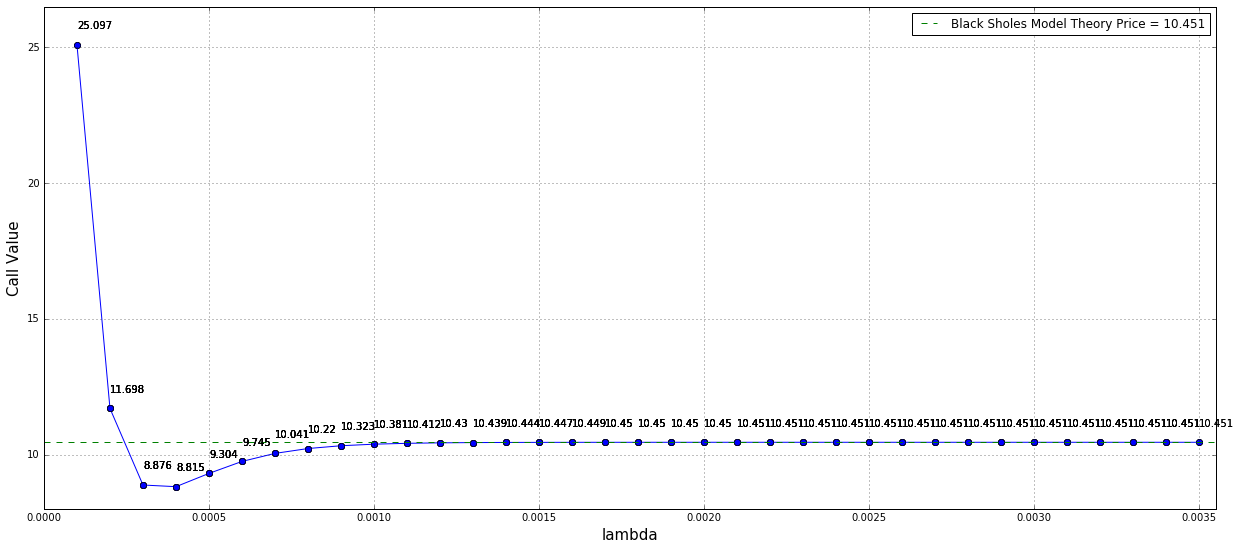

In [48]:
plt.figure(figsize=(21, 9))

lambda_ = [round(i/(10000.0),4) for i in arange(1,35,0.1)]
a = []
for i in range(0,len(lambda_)):
    a.append(Black_Scholes_Model_call_value_FFT_simpson(100.0, 100.0, 1.0, 0.05, 0.2 , 2**13,lambda_[i]))
plot(lambda_,a,'-o')

for i in arange(0,len(lambda_),2):
    plt.annotate(round(a[i],3), xy=(lambda_[i], round(a[i],4)), xytext = (lambda_[i], round(a[i],8)+0.6))
    #plt.annotate(round(a[2*i+1],4), xy=(lambda_[2*i+1], round(a[2*i+1],4)), xytext = (lambda_[2*i+1], round(a[2*i+1],8)-0.5))

#plt.annotate(round(a[1],4), xy=(lambda_[1], round(a[1],4)), xytext = (lambda_[1], round(a[1],8)+0.2))

plt.xlabel('lambda',size = 15)
plt.ylabel('Call Value',size = 15)
plt.xlim(0,0.00355)
plt.ylim(8,26.5) 
plt.axhline(10.451,color = 'g',linestyle = '--',label = 'Black Sholes Model Theory Price = 10.451')
plt.grid()
plt.legend();

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


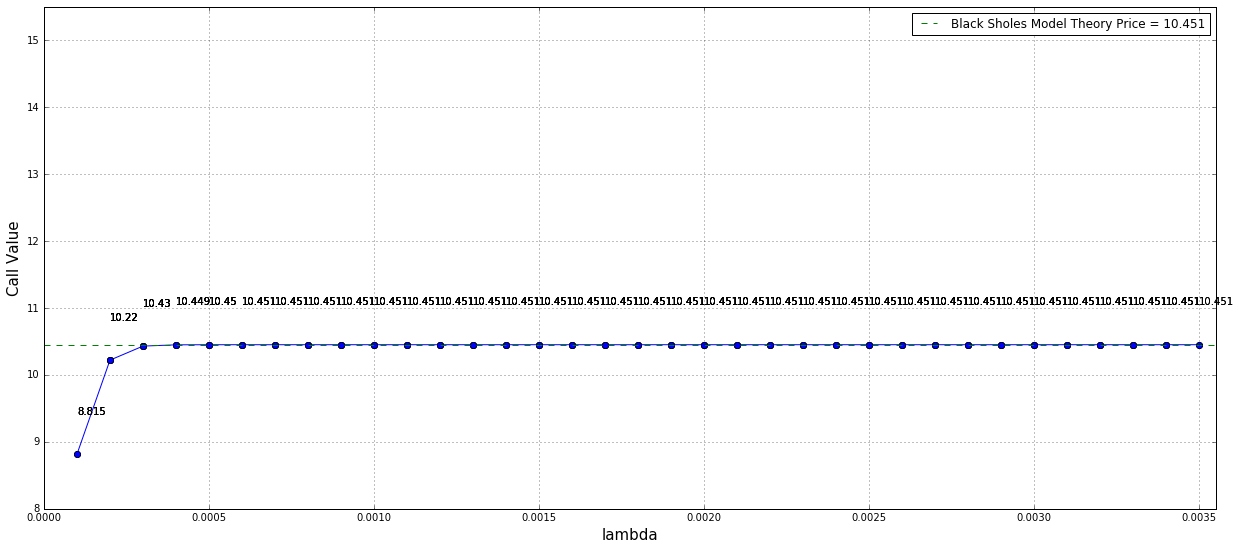

In [51]:
plt.figure(figsize=(21, 9))

lambda_ = [round(i/(10000.0),4) for i in arange(1,35,0.1)]
a = []
for i in range(0,len(lambda_)):
    a.append(Black_Scholes_Model_call_value_FFT_simpson(100.0, 100.0, 1.0, 0.05, 0.2 , 2**15,lambda_[i]))
plot(lambda_,a,'-o')

for i in arange(0,len(lambda_),2):
    plt.annotate(round(a[i],3), xy=(lambda_[i], round(a[i],4)), xytext = (lambda_[i], round(a[i],8)+0.6))
    #plt.annotate(round(a[2*i+1],4), xy=(lambda_[2*i+1], round(a[2*i+1],4)), xytext = (lambda_[2*i+1], round(a[2*i+1],8)-0.5))

#plt.annotate(round(a[1],4), xy=(lambda_[1], round(a[1],4)), xytext = (lambda_[1], round(a[1],8)+0.2))

plt.xlabel('lambda',size = 15)
plt.ylabel('Call Value',size = 15)
plt.xlim(0,0.00355)
plt.ylim(8,15.5) 
plt.axhline(10.451,color = 'g',linestyle = '--',label = 'Black Sholes Model Theory Price = 10.451')

plt.grid()
plt.legend()

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


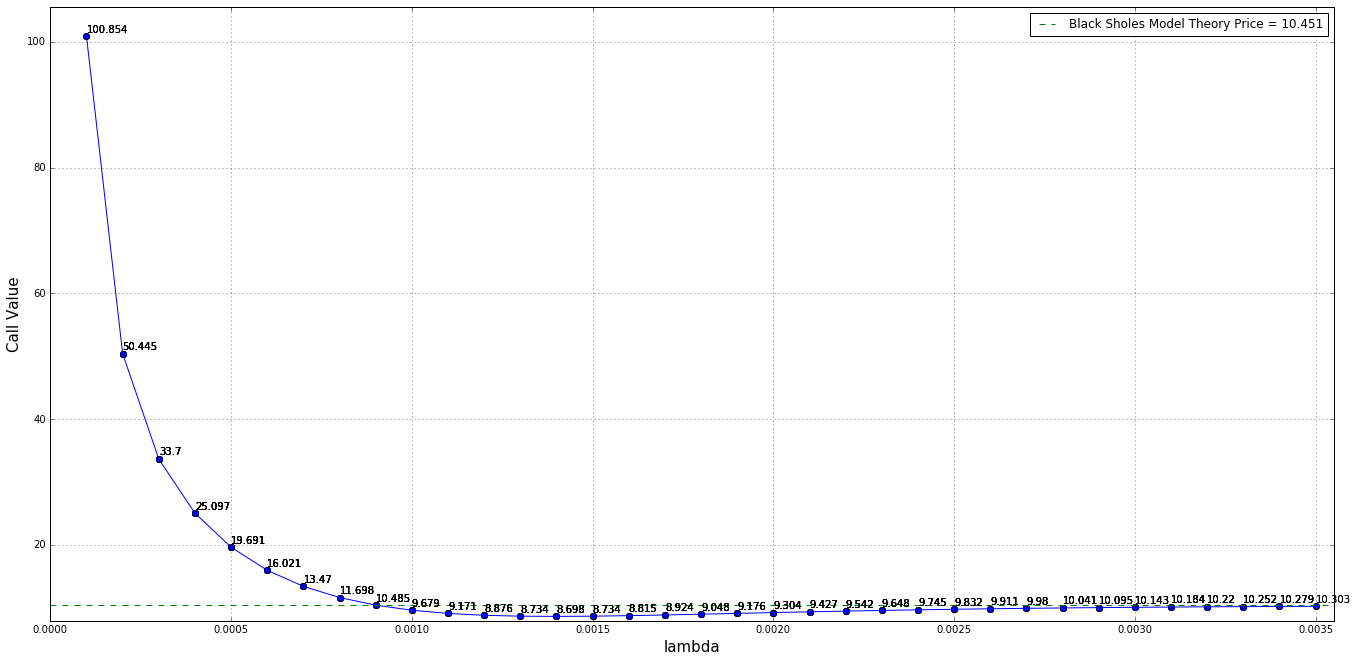

In [52]:
plt.figure(figsize=(23, 11))

lambda_ = [round(i/(10000.0),4) for i in arange(1,35,0.1)]
a = []
for i in range(0,len(lambda_)):
    a.append(Black_Scholes_Model_call_value_FFT_simpson(100.0, 100.0, 1.0, 0.05, 0.2 , 2**11,lambda_[i]))
plot(lambda_,a,'-o')

for i in arange(0,len(lambda_),2):
    plt.annotate(round(a[i],3), xy=(lambda_[i], round(a[i],4)), xytext = (lambda_[i], round(a[i],8)+0.6))
    #plt.annotate(round(a[2*i+1],4), xy=(lambda_[2*i+1], round(a[2*i+1],4)), xytext = (lambda_[2*i+1], round(a[2*i+1],8)-0.5))

#plt.annotate(round(a[1],4), xy=(lambda_[1], round(a[1],4)), xytext = (lambda_[1], round(a[1],8)+0.2))

plt.xlabel('lambda',size = 15)
plt.ylabel('Call Value',size = 15)
plt.xlim(0,0.00355)
plt.ylim(8,105.5) 
plt.axhline(10.451,color = 'g',linestyle = '--',label = 'Black Sholes Model Theory Price = 10.451')
plt.grid()
plt.legend()

/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rory/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


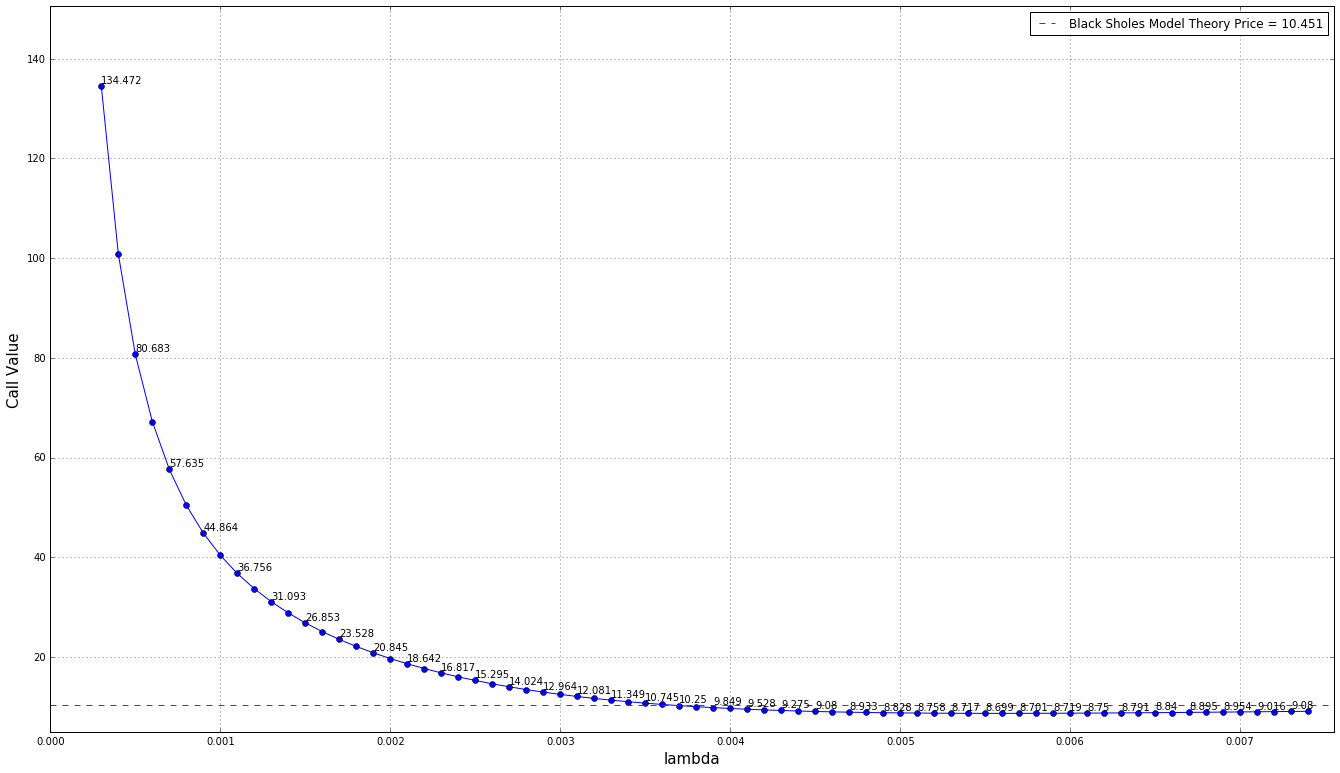

In [53]:
plt.figure(figsize=(23, 13))

lambda_ = [round(i/(10000.0),4) for i in arange(3,75,1)]
a = []
for i in range(0,len(lambda_)):
    a.append(Black_Scholes_Model_call_value_FFT_simpson(100.0, 100.0, 1.0, 0.05, 0.2 , 2**9,lambda_[i]))
plot(lambda_,a,'-o')

for i in arange(0,len(lambda_),2):
    plt.annotate(round(a[i],3), xy=(lambda_[i], round(a[i],4)), xytext = (lambda_[i], round(a[i],8)+0.6))
    #plt.annotate(round(a[2*i+1],4), xy=(lambda_[2*i+1], round(a[2*i+1],4)), xytext = (lambda_[2*i+1], round(a[2*i+1],8)-0.5))

#plt.annotate(round(a[1],4), xy=(lambda_[1], round(a[1],4)), xytext = (lambda_[1], round(a[1],8)+0.2))

plt.xlabel('lambda',size = 15)
plt.ylabel('Call Value',size = 15)
plt.xlim(0.00,0.00755)
plt.ylim(5,150.5) 
plt.axhline(10.451,color = 'g',linestyle = '--',label = 'Black Sholes Model Theory Price = 10.451')
plt.grid()
plt.legend()